In [1]:
%matplotlib inline


Word Movers' Distance
=====================

Demonstrates using Gensim's implemenation of the WMD.




Word Mover's Distance (WMD) is a promising new tool in machine learning that
allows us to submit a query and return the most relevant documents. This
tutorial introduces WMD and shows how you can compute the WMD distance
between two documents using ``wmdistance``.

WMD Basics
----------

WMD enables us to assess the "distance" between two documents in a meaningful
way, even when they have no words in common. It uses `word2vec
<http://rare-technologies.com/word2vec-tutorial/>`_ [4] vector embeddings of
words. It been shown to outperform many of the state-of-the-art methods in
*k*\ -nearest neighbors classification [3].

WMD is illustrated below for two very similar sentences (illustration taken
from `Vlad Niculae's blog
<http://vene.ro/blog/word-movers-distance-in-python.html>`_\ ). The sentences
have no words in common, but by matching the relevant words, WMD is able to
accurately measure the (dis)similarity between the two sentences. The method
also uses the bag-of-words representation of the documents (simply put, the
word's frequencies in the documents), noted as $d$ in the figure below. The
intuition behind the method is that we find the minimum "traveling distance"
between documents, in other words the most efficient way to "move" the
distribution of document 1 to the distribution of document 2.




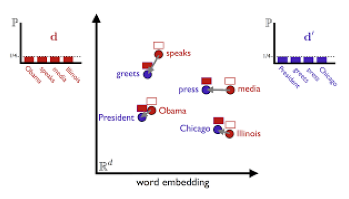

In [1]:
# Image from https://vene.ro/images/wmd-obama.png
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('images\wmd-obama.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

This method was introduced in the article "From Word Embeddings To Document
Distances" by Matt Kusner et al. (\ `link to PDF
<http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf>`_\ ). It is inspired
by the "Earth Mover's Distance", and employs a solver of the "transportation
problem".

In this tutorial, we will learn how to use Gensim's WMD functionality, which
consists of the ``wmdistance`` method for distance computation, and the
``WmdSimilarity`` class for corpus based similarity queries.

.. Important::
   If you use Gensim's WMD functionality, please consider citing [1], [2] and [3].

Computing the Word Mover's Distance
-----------------------------------

To use WMD, you need some existing word embeddings.
You could train your own Word2Vec model, but that is beyond the scope of this tutorial
(check out `sphx_glr_auto_examples_tutorials_run_word2vec.py` if you're interested).
For this tutorial, we'll be using an existing Word2Vec model.

Let's take some sentences to compute the distance between.




In [2]:
# Initialize logging.
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

sentence_obama = 'Obama speaks to the media in Illinois'
sentence_president = 'The president greets the press in Chicago'

These sentences have very similar content, and as such the WMD should be low.
Before we compute the WMD, we want to remove stopwords ("the", "to", etc.),
as these do not contribute a lot to the information in the sentences.




In [3]:
# Import and download stopwords from NLTK.
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.
stop_words = stopwords.words('english')

def preprocess(sentence):
    return [w for w in sentence.lower().split() if w not in stop_words]

sentence_obama = preprocess(sentence_obama)
sentence_president = preprocess(sentence_president)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isstyc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now, as mentioned earlier, we will be using some downloaded pre-trained
embeddings. We load these into a Gensim Word2Vec model class.

.. Important::
  The embeddings we have chosen here require a lot of memory.




In [4]:
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

2020-08-19 15:55:16,774 : INFO : 'pattern' package not found; tag filters are not available for English
2020-08-19 15:55:17,193 : INFO : loading projection weights from C:\Users\isstyc/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
2020-08-19 15:57:00,238 : INFO : loaded (3000000, 300) matrix from C:\Users\isstyc/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


So let's compute WMD using the ``wmdistance`` method.




In [6]:
distance = model.wmdistance(sentence_obama, sentence_president)
print('distance = %.4f' % distance)

2020-08-19 15:57:00,256 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-19 15:57:00,257 : INFO : built Dictionary(8 unique tokens: ['illinois', 'media', 'obama', 'speaks', 'chicago']...) from 2 documents (total 8 corpus positions)


distance = 3.3741


Let's try the same thing with two completely unrelated sentences. Notice that the distance is larger.




In [8]:
sentence_orange = preprocess('Oranges are my favorite fruit')
distance = model.wmdistance(sentence_obama, sentence_orange)
print('distance = %.4f' % distance)

2020-08-19 15:59:08,324 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-19 15:59:08,325 : INFO : built Dictionary(7 unique tokens: ['illinois', 'media', 'obama', 'speaks', 'favorite']...) from 2 documents (total 7 corpus positions)


distance = 1.3663


Normalizing word2vec vectors
^^^^^^^^^^^^^^^^^^^^^^^^^^^^

When using the ``wmdistance`` method, it is beneficial to normalize the
word2vec vectors first, so they all have equal length. To do this, simply
call ``model.init_sims(replace=True)`` and Gensim will take care of that for
you.

Usually, one measures the distance between two word2vec vectors using the
cosine distance (see `cosine similarity
<https://en.wikipedia.org/wiki/Cosine_similarity>`_\ ), which measures the
angle between vectors. WMD, on the other hand, uses the Euclidean distance.
The Euclidean distance between two vectors might be large because their
lengths differ, but the cosine distance is small because the angle between
them is small; we can mitigate some of this by normalizing the vectors.

.. Important::
  Note that normalizing the vectors can take some time, especially if you have
  a large vocabulary and/or large vectors.




In [9]:
model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.

distance = model.wmdistance(sentence_obama, sentence_president)  # Compute WMD as normal.
print('distance: %r' % distance)

distance = model.wmdistance(sentence_obama, sentence_orange)
print('distance = %.4f' % distance)

2020-08-19 15:59:13,094 : INFO : precomputing L2-norms of word weight vectors
2020-08-19 15:59:15,522 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-19 15:59:15,523 : INFO : built Dictionary(8 unique tokens: ['illinois', 'media', 'obama', 'speaks', 'chicago']...) from 2 documents (total 8 corpus positions)
2020-08-19 15:59:15,524 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-19 15:59:15,525 : INFO : built Dictionary(7 unique tokens: ['illinois', 'media', 'obama', 'speaks', 'favorite']...) from 2 documents (total 7 corpus positions)


distance: 1.0174646259300113
distance = 1.3663


References
----------

1. Ofir Pele and Michael Werman, *A linear time histogram metric for improved SIFT matching*\ , 2008.
2. Ofir Pele and Michael Werman, *Fast and robust earth mover's distances*\ , 2009.
3. Matt Kusner et al. *From Embeddings To Document Distances*\ , 2015.
4. Thomas Mikolov et al. *Efficient Estimation of Word Representations in Vector Space*\ , 2013.


